In [129]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, recall_score

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from time import time

In [2]:
car_review = pd.read_csv('car_review.csv', index_col=0)

In [3]:
car_review.head()

,Rating,Year,Review,Brand
1,4,\n by JayeMaye\n ...,\n This is what I've bought Sat...,dodge-charger-2012/consumer-reviews/
2,5,\n by Female Driver\n ...,\n I just got my Special Order ...,dodge-charger-2012/consumer-reviews/
3,5,\n by New Car Buyer\n ...,\n About 2 months ago I purchas...,dodge-charger-2012/consumer-reviews/
4,5,\n by KTisaPhillyPhan\n ...,\n We bought a tungsten metalli...,dodge-charger-2012/consumer-reviews/
5,5,\n by I<3DODGE\n ...,\n I have a 2012 Dodge Charger ...,dodge-charger-2012/consumer-reviews/


In [4]:
car_review.Rating.value_counts()

5    14704
4     3211
3      730
2      313
1      284
Name: Rating, dtype: int64

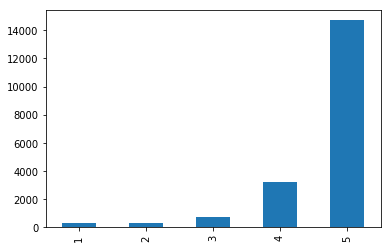

In [5]:
car_review.Rating.value_counts(sort=False).plot(kind = 'bar')
plt.show()

* Reviews are skewed towards positive

# Cleaning data and retrive features

### Car

In [6]:
car_review['Car'] = car_review.Brand.map(lambda x: x.split('/')[0])
car_review['Car_Year'] = car_review['Car'].map(lambda x: x.split('-')[-1])
car_review['Car_test'] = car_review['Car'].map(lambda x: x.split('-')[:-1])
car_review['Car_Make'] = car_review['Car_test'].map(lambda x: x[0])
car_review['Car_Model'] = car_review['Car_test'].map(lambda x: x[-1])

In [7]:
car_review.drop(['Car_test'], axis=1, inplace=True)

In [8]:
car_review.head()

,Rating,Year,Review,Brand,Car,Car_Year,Car_Make,Car_Model
1,4,\n by JayeMaye\n ...,\n This is what I've bought Sat...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
2,5,\n by Female Driver\n ...,\n I just got my Special Order ...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
3,5,\n by New Car Buyer\n ...,\n About 2 months ago I purchas...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
4,5,\n by KTisaPhillyPhan\n ...,\n We bought a tungsten metalli...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
5,5,\n by I<3DODGE\n ...,\n I have a 2012 Dodge Charger ...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger


### Reviews

In [9]:
car_review['Review'] = car_review['Review'].map(lambda x: x.rstrip().lstrip())

In [10]:
car_review['Review'].head()

1    This is what I've bought Saturday:\n2012 Dodge...
2    I just got my Special Order wiith my name on w...
3    About 2 months ago I purchased a new Dodge Cha...
4    We bought a tungsten metallic SXT-Plus Charger...
5    I have a 2012 Dodge Charger R/T Plus AWD in re...
Name: Review, dtype: object

### Date

In [11]:
from datetime import datetime

In [12]:
car_review['Review_Date'] = car_review['Year'].map(lambda x: 
                                                   datetime.strptime(x.split('\n')[-2].split('on')[-1].lstrip(), '%B %d, %Y'))
car_review['Review_Year'] = car_review['Review_Date'].map(lambda x: x.year)
car_review['Review_Month'] = car_review['Review_Date'].map(lambda x: x.month)
car_review['Review_Day'] = car_review['Review_Date'].map(lambda x: x.day)

In [13]:
car_review[['Review_Date', 'Review_Year', 'Review_Month', 'Review_Day']].head()

,Review_Date,Review_Year,Review_Month,Review_Day
1,2012-05-02,2012,5,2
2,2012-06-14,2012,6,14
3,2012-06-29,2012,6,29
4,2012-05-08,2012,5,8
5,2012-03-19,2012,3,19


### Car Age

In [14]:
int(car_review['Car_Year'][1])

2012

In [15]:
car_review['Car_Age'] = car_review['Review_Year'].map(lambda x: int(x))-car_review['Car_Year'].map(lambda x: int(x))

In [16]:
car_review['Car_Age'] = car_review['Car_Age'].map(lambda x: 0 if x==-1 else x)

In [23]:
car_review['Car_Age'].corr(car_review['Rating'])

-0.07932111336293686

There is a negative correlation between car age and rating which means that people will give newer car higher rating.

### Remove duplicate review
* There are some duplicate reviews in the dataset

In [28]:
car_review.shape

(19242, 13)

In [29]:
car_review.Review.nunique()

10821

In [30]:
car_review.Review.value_counts().head(5)

A solid compact sedan. I owned a Civic years ago, and I like the emergency brake redesign. The gas cap is gone, and the lid over the gas fill intake locks when the doors lock, and unlocks when the doors unlock. This makes a lot of sense.    52
I am very happy with my purchase. No buyers remorse at all. Fast, fun, reliable and comfortable! Would highly recommend this car to anyone. You will not find more bang for you buck.                                                            52
This is my first new car and I am happy with the comfort and look of the car.  The Civic Hatchback is great to handle and the technical aspects of the car are easy to understand.                                                               50
Excellent car. Excellent performance and very stylish. Handles excellent on the road. When you need the power this car has it with no problem.                                                                                                   50
This car is great for yo

In [31]:
car_review=car_review.drop_duplicates(subset=['Review'])

In [32]:
print('Number of unique reviews: ', car_review.Review.nunique())
print('Shape of the dataset: ', car_review.shape)

Number of unique reviews:  10821
Shape of the dataset:  (10821, 13)


In [33]:
car_review.head()

,Rating,Year,Review,Brand,Car,Car_Year,Car_Make,Car_Model,Review_Date,Review_Year,Review_Month,Review_Day,Car_Age
1,4,\n by JayeMaye\n ...,This is what I've bought Saturday:\n2012 Dodge...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-05-02,2012,5,2,0
2,5,\n by Female Driver\n ...,I just got my Special Order wiith my name on w...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-06-14,2012,6,14,0
3,5,\n by New Car Buyer\n ...,About 2 months ago I purchased a new Dodge Cha...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-06-29,2012,6,29,0
4,5,\n by KTisaPhillyPhan\n ...,We bought a tungsten metallic SXT-Plus Charger...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-05-08,2012,5,8,0
5,5,\n by I<3DODGE\n ...,I have a 2012 Dodge Charger R/T Plus AWD in re...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-03-19,2012,3,19,0


In [34]:
car_review.Rating.value_counts()

5    7815
4    1943
3     538
2     273
1     252
Name: Rating, dtype: int64

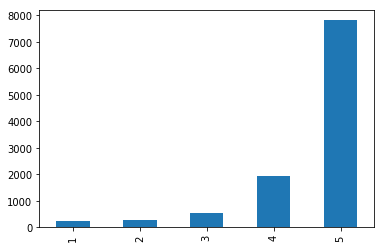

In [35]:
car_review.Rating.value_counts(sort=False).plot(kind = 'bar')
plt.show()

In [40]:
pd.crosstab(index=car_review.Rating, columns="count")/pd.crosstab(index=car_review.Rating, columns="count").sum()

col_0,count
Rating,
1,0.023288
2,0.025229
3,0.049718
4,0.179558
5,0.722207


### Create positive & negative tag 

In [41]:
car_review['tag'] = car_review['Rating'].map(lambda x:0 if x==5 else 1)

/Users/lana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
car_review['tag'].value_counts(sort=False)

0    7815
1    3006
Name: tag, dtype: int64

* I tag the reviews that the users not fully satisfied with the car.
#### 1: negative;
#### 0: positive.

# Visualization

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

max:  4076
min:  48
average:  396.6112189261621
Standard Deviation: 442.9049


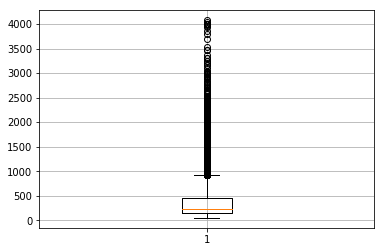

In [45]:
l=[len(i) for i in car_review.Review]
print('max: ',max(l))
print('min: ',min(l))
print('average: ',sum(l)/len(l))
print('Standard Deviation: {:.4f}'.format(np.std(l)))
plt.boxplot(l)
plt.grid(True)

In [46]:
396.6112189261621+442.9049

839.5161189261621

In [47]:
396.6112189261621+442.9049*2

1282.421018926162

# Split the data set

In [48]:
from sklearn.model_selection import train_test_split

In [130]:
x = car_review.Review
y = car_review.tag
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, random_state=10, test_size=0.2)

# Modelling with Supervised Algorithms

In [81]:
def model(preprocessing, model, trainx, trainy, testx, testy):
    preprocessing_method = preprocessing
    trainx2 = preprocessing_method.fit_transform(trainx) 
    testx2 = preprocessing_method.transform(testx)
    
    model = model.fit(trainx2, trainy)
    predict = model.predict(testx2)
    
    fpr_train, tpr_train,_=roc_curve(trainy, model.predict(trainx2))
    auc_train=auc(fpr_train, tpr_train)
    
    fpr_test, tpr_test,_=roc_curve(testy, predict)
    auc_test=auc(fpr_test, tpr_test)
    
    print('AUC(Train): {:.4f}'.format(auc_train))
    print('AUC(Test):  {:.4f}'.format(auc_test))
    print ("TRAIN Accuracy:   %0.3f" % accuracy_score(trainy, model.predict(trainx2)))
    print ("TEST Accuracy:   %0.3f" % accuracy_score(testy, predict))
    
    cm = confusion_matrix(testy, predict, labels = [0, 1])
    print('Confusion matrix, without normalization:')
    print(cm)
    print("Normalized confusion matrix:")
    print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
    print(classification_report(testy,predict))

In [89]:
def pipline_grid(parameters, pip, train_x, train_y):
    
    kfold = KFold(n_splits=3, random_state=10)
    gs = GridSearchCV(pip, parameters, cv=kfold, scoring= 'recall')
    
    print("Performing grid search...")
    print("Pipeline:", [name for name, _ in pip.steps])
    t0 = time()
    gs.fit(train_x, train_y)
    t1 = time() 
    print("Done in %0.3fs" % (t1 - t0))
    
    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters:")
    best_parameters = gs.best_estimator_.get_params()
    print(t1 - t0)
    print(best_parameters)
#     return best_parameters

## 1. Naive Bayes

### 1.1 TFIDF Vectorizer

In [92]:
model(TfidfVectorizer(), MultinomialNB(), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.5517
AUC(Test):  0.5223
TRAIN Accuracy:   0.749
TEST Accuracy:   0.743
Confusion matrix, without normalization:
[[1583    0]
 [ 556   26]]
Normalized confusion matrix:
[[1.         0.        ]
 [0.95532646 0.04467354]]
             precision    recall  f1-score   support

          0       0.74      1.00      0.85      1583
          1       1.00      0.04      0.09       582

avg / total       0.81      0.74      0.64      2165



#### Fine-tuning parameters

In [93]:
pipeline_tfidf_nb_grid = Pipeline([
    ('vect', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])


parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),  
    'vect__min_df': (1, 2, 3),
    'vect__lowercase': (True, False),
    'nb__alpha': np.arange(0.1,1.1,0.1),
}

pipline_grid(parameters, pipeline_tfidf_nb_grid, Xtrain, ytrain)

Performing grid search...
Pipeline: ['vect', 'nb']
Done in 1925.795s
Best score: 0.487
Best parameters:
1925.794723033905
{'memory': None, 'steps': [('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))], 'vect': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accen

In [109]:
model(TfidfVectorizer(lowercase = True, min_df = 3, ngram_range = (1, 3)),
      MultinomialNB(alpha = 0.1), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.8908
AUC(Test):  0.7219
TRAIN Accuracy:   0.928
TEST Accuracy:   0.819
Confusion matrix, without normalization:
[[1475  108]
 [ 284  298]]
Normalized confusion matrix:
[[0.93177511 0.06822489]
 [0.48797251 0.51202749]]
             precision    recall  f1-score   support

          0       0.84      0.93      0.88      1583
          1       0.73      0.51      0.60       582

avg / total       0.81      0.82      0.81      2165



### 1.2 Count vectorizer

In [95]:
model(CountVectorizer(), MultinomialNB(), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.7777
AUC(Test):  0.7204
TRAIN Accuracy:   0.855
TEST Accuracy:   0.818
Confusion matrix, without normalization:
[[1473  110]
 [ 285  297]]
Normalized confusion matrix:
[[0.93051169 0.06948831]
 [0.48969072 0.51030928]]
             precision    recall  f1-score   support

          0       0.84      0.93      0.88      1583
          1       0.73      0.51      0.60       582

avg / total       0.81      0.82      0.81      2165



#### Fine-tuning parameters

In [96]:
pipeline_count_nb_grid = Pipeline([
    ('vect', CountVectorizer()),
    ('nb', MultinomialNB()),
])


parameters = {
    'vect__ngram_range': ((1, 1), (1, 2),(1, 3)),  
    'vect__lowercase': (True, False),
    'vect__min_df': (1, 2, 3),
    'nb__alpha': np.arange(0.1,1.1,0.1),
}

pipline_grid(parameters, pipeline_count_nb_grid, Xtrain, ytrain)

Performing grid search...
Pipeline: ['vect', 'nb']
Done in 1545.231s
Best score: 0.575
Best parameters:
1545.230926990509
{'memory': None, 'steps': [('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=0.4, class_prior=None, fit_prior=True))], 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), 'nb': Multin

In [110]:
model(CountVectorizer(lowercase = True, min_df = 3, ngram_range = (1, 3)),
      MultinomialNB(alpha = 0.4), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.8804
AUC(Test):  0.7415
TRAIN Accuracy:   0.916
TEST Accuracy:   0.817
Confusion matrix, without normalization:
[[1431  152]
 [ 245  337]]
Normalized confusion matrix:
[[0.90397979 0.09602021]
 [0.4209622  0.5790378 ]]
             precision    recall  f1-score   support

          0       0.85      0.90      0.88      1583
          1       0.69      0.58      0.63       582

avg / total       0.81      0.82      0.81      2165



## 2. Logistic Regression

### 2.1 TFIDF Vectorizer

In [98]:
model(TfidfVectorizer(), LogisticRegression(), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.7588
AUC(Test):  0.7005
TRAIN Accuracy:   0.852
TEST Accuracy:   0.817
Confusion matrix, without normalization:
[[1508   75]
 [ 321  261]]
Normalized confusion matrix:
[[0.9526216  0.0473784 ]
 [0.55154639 0.44845361]]
             precision    recall  f1-score   support

          0       0.82      0.95      0.88      1583
          1       0.78      0.45      0.57       582

avg / total       0.81      0.82      0.80      2165



#### Fine-tuning parameters

In [99]:
pipeline_tfidf_lg_grid = Pipeline([
    ('vect', TfidfVectorizer()),
    ('lg', LogisticRegression()),
])


parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),  
    'vect__min_df': (1, 2, 3),
    'vect__lowercase': (True, False),
    'lg__C': [0.001,0.01,0.1,1,10,100],
}

pipline_grid(parameters, pipeline_tfidf_lg_grid, Xtrain, ytrain)

Performing grid search...
Pipeline: ['vect', 'lg']
Done in 1272.733s
Best score: 0.511
Best parameters:
1272.7330651283264
{'memory': None, 'steps': [('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('lg', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))], 'vect': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, enc

In [111]:
model(TfidfVectorizer(ngram_range = (1,1), min_df=3, lowercase=False),
      LogisticRegression(C=100), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.9810
AUC(Test):  0.6987
TRAIN Accuracy:   0.989
TEST Accuracy:   0.769
Confusion matrix, without normalization:
[[1347  236]
 [ 264  318]]
Normalized confusion matrix:
[[0.85091598 0.14908402]
 [0.45360825 0.54639175]]
             precision    recall  f1-score   support

          0       0.84      0.85      0.84      1583
          1       0.57      0.55      0.56       582

avg / total       0.77      0.77      0.77      2165



### 2.2 Count vectorizer

In [100]:
model(CountVectorizer(), LogisticRegression(), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.8997
AUC(Test):  0.6985
TRAIN Accuracy:   0.940
TEST Accuracy:   0.793
Confusion matrix, without normalization:
[[1428  155]
 [ 294  288]]
Normalized confusion matrix:
[[0.90208465 0.09791535]
 [0.50515464 0.49484536]]
             precision    recall  f1-score   support

          0       0.83      0.90      0.86      1583
          1       0.65      0.49      0.56       582

avg / total       0.78      0.79      0.78      2165



#### Fine-tuning parameters

In [101]:
pipeline_count_lg_grid = Pipeline([
    ('vect', CountVectorizer()),
    ('lg', LogisticRegression()),
])


parameters = {
    'vect__ngram_range': ((1, 1), (1, 2),(1, 3)),  
    'vect__lowercase': (True, False),
    'vect__min_df': (1, 2, 3),
    'lg__C': [0.001,0.01,0.1,1,10,100],
}

pipline_grid(parameters, pipeline_count_lg_grid, Xtrain, ytrain)

Performing grid search...
Pipeline: ['vect', 'lg']
Done in 1116.358s
Best score: 0.506
Best parameters:
1116.3584427833557
{'memory': None, 'steps': [('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('lg', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))], 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, ma

In [126]:
model(CountVectorizer(ngram_range = (1,1), min_df=3, lowercase=False),
      LogisticRegression(C = 10), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.9763
AUC(Test):  0.6845
TRAIN Accuracy:   0.986
TEST Accuracy:   0.755
Confusion matrix, without normalization:
[[1324  259]
 [ 272  310]]
Normalized confusion matrix:
[[0.83638661 0.16361339]
 [0.46735395 0.53264605]]
             precision    recall  f1-score   support

          0       0.83      0.84      0.83      1583
          1       0.54      0.53      0.54       582

avg / total       0.75      0.75      0.75      2165



## 3. Linear support vector classifier

### 3.1 TFIDF Vectorizer

In [102]:
model(TfidfVectorizer(),LinearSVC(), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.8971
AUC(Test):  0.7146
TRAIN Accuracy:   0.937
TEST Accuracy:   0.802
Confusion matrix, without normalization:
[[1430  153]
 [ 276  306]]
Normalized confusion matrix:
[[0.90334807 0.09665193]
 [0.4742268  0.5257732 ]]
             precision    recall  f1-score   support

          0       0.84      0.90      0.87      1583
          1       0.67      0.53      0.59       582

avg / total       0.79      0.80      0.79      2165



#### Fine-tuning parameters

In [103]:
pipeline_tfidf_lsvc_grid = Pipeline([
    ('vect', TfidfVectorizer()),
    ('lsvc', LinearSVC()),
])

parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),  
    'vect__min_df': (1, 2, 3),
    'vect__lowercase': (True, False),
    'lsvc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lsvc__loss': ['hinge', 'squared_hinge'],
}

pipline_grid(parameters, pipeline_tfidf_lsvc_grid, Xtrain, ytrain)

Performing grid search...
Pipeline: ['vect', 'lsvc']
Done in 2816.752s
Best score: 0.512
Best parameters:
2816.7515149116516
{'memory': None, 'steps': [('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('lsvc', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))], 'vect': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercas

In [127]:
model(TfidfVectorizer(ngram_range = (1,2), min_df=3, lowercase=True),
      LinearSVC(C =10 , loss = 'squared_hinge'), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 1.0000
AUC(Test):  0.7184
TRAIN Accuracy:   1.000
TEST Accuracy:   0.791
Confusion matrix, without normalization:
[[1385  198]
 [ 255  327]]
Normalized confusion matrix:
[[0.87492104 0.12507896]
 [0.43814433 0.56185567]]
             precision    recall  f1-score   support

          0       0.84      0.87      0.86      1583
          1       0.62      0.56      0.59       582

avg / total       0.78      0.79      0.79      2165



### 3.2 Count vectorizer

In [105]:
model(CountVectorizer(),LinearSVC(), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.9778
AUC(Test):  0.6786
TRAIN Accuracy:   0.987
TEST Accuracy:   0.752
Confusion matrix, without normalization:
[[1327  256]
 [ 280  302]]
Normalized confusion matrix:
[[0.83828174 0.16171826]
 [0.48109966 0.51890034]]
             precision    recall  f1-score   support

          0       0.83      0.84      0.83      1583
          1       0.54      0.52      0.53       582

avg / total       0.75      0.75      0.75      2165



#### Fine-tuning parameters

In [106]:
pipeline_count_lsvc_grid = Pipeline([
    ('vect', CountVectorizer()),
    ('lsvc', LinearSVC()),
])

parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),  
    'vect__lowercase': (True, False),
    'vect__min_df': (1, 2, 3),
    'lsvc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lsvc__loss': ['hinge', 'squared_hinge'],
}

pipline_grid(parameters, pipeline_count_lsvc_grid, Xtrain, ytrain)

Performing grid search...
Pipeline: ['vect', 'lsvc']
Done in 2930.277s
Best score: 0.506
Best parameters:
2930.277132987976
{'memory': None, 'steps': [('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('lsvc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))], 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1,

In [112]:
model(CountVectorizer(ngram_range = (1, 1), lowercase = True, min_df = 1),
      LinearSVC(C = 1), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.9778
AUC(Test):  0.6789
TRAIN Accuracy:   0.987
TEST Accuracy:   0.753
Confusion matrix, without normalization:
[[1328  255]
 [ 280  302]]
Normalized confusion matrix:
[[0.83891346 0.16108654]
 [0.48109966 0.51890034]]
             precision    recall  f1-score   support

          0       0.83      0.84      0.83      1583
          1       0.54      0.52      0.53       582

avg / total       0.75      0.75      0.75      2165



## 4. K Nearest Neighbors Classifier

### 4.1 TFIDF Vectorizer

In [116]:
model(TfidfVectorizer(), KNeighborsClassifier(), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.7221
AUC(Test):  0.6226
TRAIN Accuracy:   0.827
TEST Accuracy:   0.764
Confusion matrix, without normalization:
[[1468  115]
 [ 397  185]]
Normalized confusion matrix:
[[0.92735313 0.07264687]
 [0.68213058 0.31786942]]
             precision    recall  f1-score   support

          0       0.79      0.93      0.85      1583
          1       0.62      0.32      0.42       582

avg / total       0.74      0.76      0.74      2165



#### Fine-tuning parameters

In [123]:
pipeline_tfidf_knn_grid = Pipeline([
    ('vect', TfidfVectorizer()),
    ('knn', KNeighborsClassifier()),
])

parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),  
    'vect__min_df': (1, 2, 3),
    'vect__lowercase': (True, False),
    'knn__n_neighbors': list(range(5, 81, 4)),
}

pipline_grid(parameters, pipeline_tfidf_knn_grid, Xtrain, ytrain)

Performing grid search...
Pipeline: ['vect', 'knn']
Done in 8322.977s
Best score: 0.386
Best parameters:
8322.977272987366
{'memory': None, 'steps': [('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))], 'vect': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
    

In [128]:
model(TfidfVectorizer(ngram_range = (1,2), min_df=3, lowercase=True),
      KNeighborsClassifier(n_neighbors=5), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.7406
AUC(Test):  0.6465
TRAIN Accuracy:   0.829
TEST Accuracy:   0.758
Confusion matrix, without normalization:
[[1405  178]
 [ 346  236]]
Normalized confusion matrix:
[[0.88755527 0.11244473]
 [0.59450172 0.40549828]]
             precision    recall  f1-score   support

          0       0.80      0.89      0.84      1583
          1       0.57      0.41      0.47       582

avg / total       0.74      0.76      0.74      2165



### 4.2 Count vectorizer

In [117]:
model(CountVectorizer(),KNeighborsClassifier(), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.6101
AUC(Test):  0.5407
TRAIN Accuracy:   0.772
TEST Accuracy:   0.731
Confusion matrix, without normalization:
[[1508   75]
 [ 507   75]]
Normalized confusion matrix:
[[0.9526216  0.0473784 ]
 [0.87113402 0.12886598]]
             precision    recall  f1-score   support

          0       0.75      0.95      0.84      1583
          1       0.50      0.13      0.20       582

avg / total       0.68      0.73      0.67      2165



#### Fine-tuning parameters

In [124]:
pipeline_count_knn_grid = Pipeline([
    ('vect', CountVectorizer()),
    ('knn', KNeighborsClassifier()),
])

parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),  
    'vect__lowercase': (True, False),
    'vect__min_df': (1, 2, 3),
    'knn__n_neighbors': list(range(5, 81, 4)),
}

pipline_grid(parameters, pipeline_count_knn_grid, Xtrain, ytrain)

Performing grid search...
Pipeline: ['vect', 'knn']
Done in 8032.734s
Best score: 0.214
Best parameters:
8032.734415054321
{'memory': None, 'steps': [('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(2, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))], 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(2, 2), preprocessor=None, stop_words=None,
        

In [133]:
model(CountVectorizer(ngram_range = (2, 2), lowercase = False, min_df = 3),
      KNeighborsClassifier(n_neighbors=5), Xtrain, ytrain, Xtest, ytest)

AUC(Train): 0.7027
AUC(Test):  0.5180
TRAIN Accuracy:   0.814
TEST Accuracy:   0.698
Confusion matrix, without normalization:
[[1436  147]
 [ 507   75]]
Normalized confusion matrix:
[[0.90713834 0.09286166]
 [0.87113402 0.12886598]]
             precision    recall  f1-score   support

          0       0.74      0.91      0.81      1583
          1       0.34      0.13      0.19       582

avg / total       0.63      0.70      0.65      2165



# Summary

In [138]:
metrics = ['TF-IDF: recall', 'TF-IDF: AUC', 'TF-IDF: Accuracy', 
           'Count Vectorizer: recall', 'Count Vectorizer: AUC', 'Count Vectorizer: Accuracy']
nb = [0.51, 0.7219, 0.819, 0.58, 0.7415, 0.817]
lr = [0.55, 0.6987, 0.769, 0.53, 0.6845, 0.755]
svc = [0.56, 0.7184, 0.791, 0.52, 0.6789, 0.753]
knn = [0.41, 0.6465, 0.758, 0.13, 0.5180, 0.6980]
pd.DataFrame({ "Naive Bayes":nb, "Logistic Regression":lr, "Linear SVC":svc, "K-Nearest Neighbor":knn},
            index = metrics)

,K-Nearest Neighbor,Linear SVC,Logistic Regression,Naive Bayes
TF-IDF: recall,0.4100,0.5600,0.5500,0.5100
TF-IDF: AUC,0.6465,0.7184,0.6987,0.7219
TF-IDF: Accuracy,0.7580,0.7910,0.7690,0.8190
Count Vectorizer: recall,0.1300,0.5200,0.5300,0.5800
Count Vectorizer: AUC,0.5180,0.6789,0.6845,0.7415
Count Vectorizer: Accuracy,0.6980,0.7530,0.7550,0.8170
